In [1]:
import sys
sys.path.append('.')

In [2]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [3]:
# setting CUDA to load modules lazily
# Only available on CUDA 11.7+
# os.environ['CUDA_MODULE_LOADING'] = 'LAZY'

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms as T

In [4]:
import time
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/unet_cotnet_{int(time.time())}")

2023-07-14 13:17:04.357686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 13:17:04.515387: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-14 13:17:04.970614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-14 13:17:04.970666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from change_detection.models.layers import layers
from change_detection.models import models
from change_detection import dataset
from loss.cross_entropy import EdgeCrossEntropy

In [6]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def get_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    return info.used//1024**2


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [7]:
print_gpu_utilization()

GPU memory occupied: 258 MB.


In [8]:
get_gpu_utilization()

258

In [9]:
# # preparing cropped stuff for train, val, and test datasets
ds_path = Path("/home/m/data/projects/dr.eftekhari - change detection/CoTNet/dataset/LEVIR-CD").resolve()
# dataset.make_cropped_dataset(ds_path / "train")
# dataset.make_cropped_dataset(ds_path / "val")
# dataset.make_cropped_dataset(ds_path / "test")

In [10]:
train_ds = dataset.LevirCDDataset(ds_path, limit = 48000, partition = "train")
val_ds = dataset.LevirCDDataset(ds_path, limit = 20000, partition = "val")
test_ds = dataset.LevirCDDataset(ds_path, partition = "test")

In [11]:
len(train_ds), len(test_ds), len(val_ds)

(48000, 25088, 12544)

In [12]:
print_gpu_utilization()

GPU memory occupied: 258 MB.


In [13]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 4}
max_epochs = 2
learning_rate = 1e-4

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, **params)
test_loader = DataLoader(test_ds, **params)

In [14]:
print_gpu_utilization()

GPU memory occupied: 258 MB.


In [15]:
# Define model
model = models.UnetCotnetNetwork(in_channels=3, classes=2)
if not next(model.parameters()).is_cuda:
    model.to(device)
criterion = EdgeCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
print_gpu_utilization()

GPU memory occupied: 1049 MB.


In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list)

18115222

In [18]:
class PyTMinMaxScalerVectorized(object):
    """
    Transforms each channel to the range [0, 1].
    """
    def __call__(self, tensor):
        scale = 1.0 / (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0]) 
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])

In [19]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    min_val_loss = np.inf
    for epoch in range(1, n_epochs+1):
        torch.cuda.empty_cache()
        model.train()
        print_gpu_utilization()
        train_loss = 0.0
        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs[:, :3, :, :], imgs[:, 3:, :, :])
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            torch.cuda.empty_cache()

        # if epoch%3 == 0:
            # validation
        val_loss = 0.0
        model.eval()
        # imgs, labels = imgs.to('cpu'), labels.to('cpu')
        torch.cuda.empty_cache()
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader):
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs[:, :3, :, :], imgs[:, 3:, :, :])
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        print('=========\n{} Epoch {}\nTraining loss {}\nValidation loss {}'.format(
        datetime.datetime.now(), epoch,
        train_loss,
        val_loss
        ))
        writer.add_scalar("Train loss/epoch", train_loss / len(train_loader), epoch)
        writer.add_scalar("Validation loss/epoch", val_loss / len(val_loader), epoch)
        writer.add_scalar("GPU Utilized/epoch", get_gpu_utilization(), epoch)
        torch.cuda.empty_cache()
        print_gpu_utilization()

        # save each epochs weights
        if min_val_loss > val_loss:
            min_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"./unet_cotnet.{epoch}.pth")

In [20]:
training_loop(30, optimizer, model, criterion, train_loader)

GPU memory occupied: 1049 MB.


  0%|                                                                                                                                                                    | 0/6000 [00:00<?, ?it/s]/home/m/.local/lib/python3.10/site-packages/cupy/cuda/compiler.py:464: UserWarning: cupy.cuda.compile_with_cache has been deprecated in CuPy v10, and will be removed in the future. Use cupy.RawModule or cupy.RawKernel instead.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:35<00:00, 32.99it/s]


2023-07-14 04:08:18.032536 Epoch 1
Training loss 0.7547272253731887
Validation loss 0.6542432120031848
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:33<00:00, 33.48it/s]


2023-07-14 04:32:46.475508 Epoch 2
Training loss 0.5453564949929715
Validation loss 0.47400997202767403
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.10it/s]


2023-07-14 04:56:51.465881 Epoch 3
Training loss 0.41606950576106705
Validation loss 0.37022064743107375
GPU memory occupied: 2215 MB.
GPU memory occupied: 2215 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.11it/s]


2023-07-14 05:20:41.677909 Epoch 4
Training loss 0.33190409604211646
Validation loss 0.29768188662199796
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.24it/s]


2023-07-14 05:44:31.589361 Epoch 5
Training loss 0.2750035202230016
Validation loss 0.2816027793510608
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.25it/s]


2023-07-14 06:08:16.510565 Epoch 6
Training loss 0.23749750511099896
Validation loss 0.31186165368868685
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:33<00:00, 33.43it/s]


2023-07-14 06:31:58.947659 Epoch 7
Training loss 0.21035312778378526
Validation loss 0.21268679572706473
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:33<00:00, 33.47it/s]


2023-07-14 06:55:39.910723 Epoch 8
Training loss 0.19016479404767353
Validation loss 0.24680199982284814
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.36it/s]


2023-07-14 07:19:20.461018 Epoch 9
Training loss 0.1754808554239571
Validation loss 0.20546709866576582
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:33<00:00, 33.46it/s]


2023-07-14 07:43:04.337520 Epoch 10
Training loss 0.16280408871360122
Validation loss 0.18563402418702918
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.16it/s]


2023-07-14 08:06:47.929963 Epoch 11
Training loss 0.14814074980778
Validation loss 0.16752284278912583
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.21it/s]


2023-07-14 08:30:37.382980 Epoch 12
Training loss 0.13456365314126015
Validation loss 0.17868275872232126
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.17it/s]


2023-07-14 08:54:25.652715 Epoch 13
Training loss 0.12029791996690134
Validation loss 0.16442937615840714
GPU memory occupied: 2211 MB.
GPU memory occupied: 2211 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.21it/s]


2023-07-14 09:18:15.819841 Epoch 14
Training loss 0.10780536029425761
Validation loss 0.15414327618010265
GPU memory occupied: 2211 MB.
GPU memory occupied: 2211 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.13it/s]


2023-07-14 09:42:07.804453 Epoch 15
Training loss 0.09144187909054259
Validation loss 0.15668059753406108
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.07it/s]


2023-07-14 10:05:59.449593 Epoch 16
Training loss 0.07672284710438301
Validation loss 0.14930702445610444
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.07it/s]


2023-07-14 10:29:54.204079 Epoch 17
Training loss 0.061861344840067126
Validation loss 0.14504715351729977
GPU memory occupied: 2211 MB.
GPU memory occupied: 2211 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:35<00:00, 32.83it/s]


2023-07-14 10:53:52.018496 Epoch 18
Training loss 0.04807171837023149
Validation loss 0.16120214928868132
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:34<00:00, 33.02it/s]


2023-07-14 11:17:49.900372 Epoch 19
Training loss 0.030073823476520677
Validation loss 0.13029958469536612
GPU memory occupied: 2213 MB.
GPU memory occupied: 2213 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:35<00:00, 32.76it/s]


2023-07-14 11:41:49.051735 Epoch 20
Training loss 0.014038467252627015
Validation loss 0.13759967944660814
GPU memory occupied: 2215 MB.
GPU memory occupied: 2215 MB.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3136/3136 [01:38<00:00, 31.73it/s]


2023-07-14 12:06:15.203484 Epoch 21
Training loss 0.00026890090915064016
Validation loss 0.14797475552946635
GPU memory occupied: 2243 MB.
GPU memory occupied: 2243 MB.


 20%|██████████████████████████████▍                                                                                                                          | 1193/6000 [04:37<18:38,  4.30it/s]


KeyboardInterrupt: 

In [21]:
writer.close()

### Loading Model for inference

In [42]:
def handle_output(model, imgs):
    model.eval()
    outputs = model(imgs[:, :3, :, :], imgs[:, 3:, :, :])
    outputs = nn.Sigmoid()(outputs)
    outputs = torch.where(outputs > 0.3, 1.0, 0.0)
    return outputs

In [43]:
torch.cuda.empty_cache()

In [17]:
model = models.UnetCotnetNetwork(in_channels=3, classes=2)
if not next(model.parameters()).is_cuda:
    model.to(device)
criterion = EdgeCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load("./unet_cotnet.11.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [18]:
torch.cuda.empty_cache()
imgs, labels = next(iter(test_loader))
imgs, labels = imgs.to(device), labels.to(device)

In [25]:
imgs.shape

torch.Size([4, 6, 128, 128])

In [26]:
labels.shape

torch.Size([4, 2, 128, 128])

In [27]:
imgs[0, :, :, :].squeeze(0).shape

torch.Size([6, 128, 128])

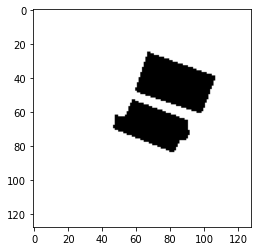

In [30]:
plt.imshow(labels[1,0,:,:].detach().cpu().numpy(), cmap="gray")

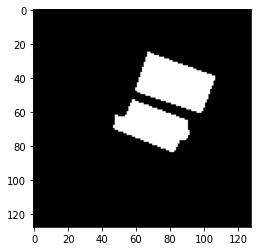

In [31]:
plt.imshow(labels[1,1,:,:].detach().cpu().numpy(), cmap="gray")

In [44]:
outputs = handle_output(model, imgs)

In [45]:
outputs.shape

torch.Size([4, 2, 128, 128])

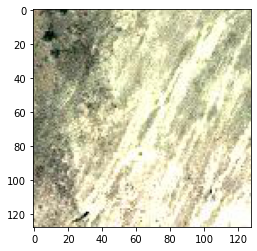

In [50]:
plt.imshow(imgs[1, :3, :, :].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

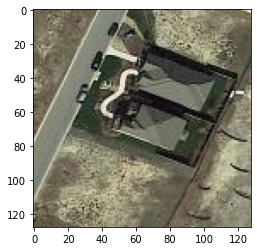

In [51]:
plt.imshow(imgs[1, 3:6, :, :].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

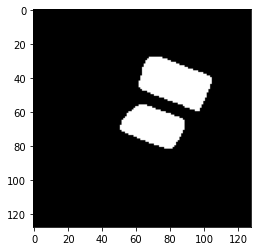

In [46]:
plt.imshow((outputs[1, 1, :, :].detach().cpu().numpy() * 255).astype(np.uint8), cmap="gray")

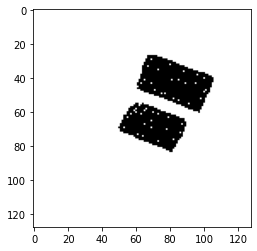

In [47]:
plt.imshow((outputs[1, 0, :, :].detach().cpu().numpy() * 255).astype(np.uint8), cmap="gray")